## **1. Mount google drive**
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to be current folder
import os
os.chdir('/content/drive/MyDrive/MyColab/coviddata')
!ls

Mounted at /content/drive
2020VAERSDATA.csv	 model.bin
2020VAERSSYMPTOMS.csv	 test.txt
2020VAERSVAX.csv	 vaers_data_complete_2021_09_06
2021VAERSDATA.csv	 vaers_data_complete_2021_09_08
2021VAERSSYMPTOMS.csv	 vaers_data_complete_text_processed_2021-11-08.csv
2021VAERSVAX.csv	 WordEmbedding
data_complete_final.csv  WordVec
Model_09_10_10Symptoms


## **2. Import the necessary libraries**
---

In [ ]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from gensim.models import Word2Vec


from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D,AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.6.0
numpy:       1.19.5
matplotlib:  3.2.2
sklearn:     0.22.2.post1


In [ ]:
import pickle
#load the preprocessing data done in Bert Model
with open("data_complete_final.csv", "rb") as fp: 
  data_complete = pickle.load(fp)
print('data_complete2r loaded!')

data_complete2r loaded!


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import spacy

#Text Processing
#lower casing the sentences
def lower_casing(sentence):
    new_sentence = sentence.lower()
    return new_sentence

#Abbreviation expansion
def expand_abbriviation(sentence):
    replacement_patterns = [
        (r'won\'t', 'will not'),
        (r'can\'t', 'cannot'),
        (r'i\'m', 'i am'),
        (r'ain\'t', 'is not'),
        (r'(\w+)\'ll', '\g<1> will'),
        (r'(\w+)n\'t', '\g<1> not'),
        (r'(\w+)\'ve', '\g<1> have'),
        (r'(\w+)\'s', '\g<1> is'),
        (r'(\w+)\'re', '\g<1> are'),
        (r'(\w+)\'d', '\g<1> would')]
    patterns = [(re.compile(regex), repl) for (regex, repl) in replacement_patterns]

    new_sentence = sentence
    for (pattern, repl) in patterns:
        (new_sentence, count) = re.subn(pattern, repl, new_sentence)
    return new_sentence

def remove_numbers(sentence):
    # define the pattern to keep
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', sentence)

#Punctuation removal
def punctuation_removal(sentence):
    # Remove the all the punctuations except '
    new_sentence = re.sub(';|\\\|:|,|!|\?|\"|<|>|\(|\)|\[|\]|\{|\}|@|#|\+|\=|\-|\_|~|\&|\*|\^|%|\||\$|/|`|\.|\'',
                          ' ', sentence,count=0, flags=0)
    return new_sentence

#Sentence tokenization
def tokenization(sentence):
    new_sentence = nltk.word_tokenize(sentence)
    return new_sentence

#Stopwords removal
def stopword_removal(sentence):
    stoplist = stopwords.words('english')
    new_sentence = [word for word in sentence if word not in stoplist]
    return new_sentence

#lemmatization
def get_wordnet_pos(word):
    pack = nltk.pos_tag([word])
    tag = pack[0][1]
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV

    else:
        return None

#Lemmatization
def lemmatization(sentence):
    lemmatizer = nltk.stem.WordNetLemmatizer()

    new_sentence = [lemmatizer.lemmatize(word, get_wordnet_pos(word) or wordnet.NOUN) for word in sentence]

    return new_sentence

def text_preprocessing(raw_sentence):
    sentence = lower_casing(raw_sentence)
    sentence = expand_abbriviation(sentence)
    sentence = remove_numbers(sentence)
    sentence = punctuation_removal(sentence)
    sentence = tokenization(sentence)
    sentence = stopword_removal(sentence)
    sentence = lemmatization(sentence)
    sentence = ' '.join(sentence)
    return sentence


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#Execute text processing function on all single text
vaers_data_complete_text_processed = data_complete['SYMPTOM_TEXT'].map(text_preprocessing)
vaers_data_complete_text_processed


0         symptom occur almost immediately ache joint fe...
1         extreme pain muscle weakness right arm severe ...
2                                   soreness area itch rash
3         sore arm fever chill ache muscle flu like symp...
4         patient present clinic today report receive nd...
                                ...                        
384009    systemic dizziness lightheadnessmild additiona...
384010    systemic dizziness lightheadnesssevere systemi...
384011    systemic fainting unresponsivemedium additiona...
384012    systemic confusionsevere systemic diarrheamedi...
384013    systemic fainting unresponsivemild systemic hy...
Name: SYMPTOM_TEXT, Length: 384014, dtype: object

In [ ]:
#Define tokenizer and fit all preprocessing text into it
df_symptom_text_list = list(vaers_data_complete_text_processed)
tokenizer_full = Tokenizer()
tokenizer_full.fit_on_texts(df_symptom_text_list)

#transform the preprocessing text into token and do padding accordingly to fit the max length of the text in dataset
full_symptoms_tokenized = tokenizer_full.texts_to_sequences(df_symptom_text_list)
max_length = max([len(s.split()) for s in df_symptom_text_list])
X = pad_sequences(full_symptoms_tokenized, maxlen=max_length, padding='post')
y = data_complete.iloc[:,2:].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
#prepare token for the text sequences for WordVec model
df_symptom_text_sequences = [ text.split() for text in df_symptom_text_list]
df_symptom_text_sequences[1]

['extreme',
 'pain',
 'muscle',
 'weakness',
 'right',
 'arm',
 'severe',
 'could',
 'move',
 'arm',
 'extreme',
 'vertigo',
 'tremor',
 'throughout',
 'body',
 'hand',
 'fingertip',
 'numbness',
 'hand',
 'fever',
 'chill',
 'fatigue',
 'high',
 'blood',
 'pressure',
 'walk',
 'clinic',
 'doctor',
 'thought',
 'stroke']

In [ ]:
symptom_type   = list(data_complete.iloc[:,2:].columns)

In [ ]:
# train word2vec model
WordVecModel = Word2Vec(df_symptom_text_sequences, size=200, window=5, workers=8, min_count=1)
# summarize vocabulary size in model
words = list(WordVecModel.wv.vocab)

In [ ]:
# total vocabulary size plus 0 for unknown words
vocab_size = len(tokenizer_full.word_index) + 1
# define weight matrix dimensions with all 0
weight_matrix = np.zeros((vocab_size, 200))
# step vocab, store vectors using the Tokenizer's integer mapping
for word, i in tokenizer_full.word_index.items():
  weight_matrix[i] = np.asarray(WordVecModel.wv[word], dtype='float32')

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.losses import Loss

#define the function to calculate the class weights of the dataset
def calculating_class_weights(y_true):
    from sklearn.utils.class_weight import compute_class_weight
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights
#class to define custom loss function for different class weight
class custom_loss(Loss):
  weights = {}
  def __init__(self,weights):
    super().__init__()
    self.weights = weights

  def call(self, y_true, y_logit):
      '''
      Multi-label cross-entropy
      * Required "Wp", "Wn" as positive & negative class-weights
      y_true: true value
      y_logit: predicted value
      '''
      bce = tf.keras.losses.BinaryCrossentropy()
      loss = K.mean((self.weights[:,0]**(1-tf.cast(y_true, tf.float32)))*(self.weights[:,1]**(tf.cast(y_true, tf.float32)))*bce(y_true, y_logit), axis=-1)
      return loss

class_weights_train = calculating_class_weights(y_train)
class_weights_test = calculating_class_weights(y_test)

In [ ]:
#define the CNN model for text classification
modelname   = 'WordVec'
modelname_Final = 'WordVec_Final'
num_classes = len(symptom_type)

def createModel(modelname,num_classes,weight_matrix):
  input = Input(shape=(max_length,))
  x = Embedding(vocab_size, 200,weights=[weight_matrix],  input_length=max_length,trainable=False)(input)
  
  x = Conv1D(filters=200, kernel_size=8,strides=2,padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.1)(x)

  x = Conv1D(filters=200, kernel_size=8,strides=2,padding='same')(x)
  x = Activation('relu')(x)
  x = AveragePooling1D(padding='same',pool_size=2)(x)

  x = Conv1D(filters=300, kernel_size=8,strides=2,padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.1)(x)

  x = Conv1D(filters=300, kernel_size=8,strides=2,padding='same')(x)
  x = Activation('relu')(x)
  x = AveragePooling1D(padding='same',pool_size=2)(x)

  x = Conv1D(filters=400, kernel_size=4,padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.1)(x)

  x = Conv1D(filters=400, kernel_size=4,padding='same')(x)
  x = Activation('relu')(x)
  x = AveragePooling1D(padding='same',pool_size=2)(x)

  x = Flatten()(x)
  x = Dense(100,activation='relu')(x)
  x = Dropout(0.25)(x)
  x = Dense(num_classes,activation='sigmoid')(x)
  model = Model(inputs=input,outputs=x)
  model.compile(loss=custom_loss(class_weights_train), optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.8),tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')])
  return model

model       = createModel(modelname,num_classes,weight_matrix) # This is meant for training
modelGo     = createModel(modelname_Final,num_classes,weight_matrix) # This is used for final testing  
print(model.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2845)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2845, 200)         14527800  
_________________________________________________________________
conv1d (Conv1D)              (None, 1423, 200)         320200    
_________________________________________________________________
batch_normalization (BatchNo (None, 1423, 200)         800       
_________________________________________________________________
activation (Activation)      (None, 1423, 200)         0         
_________________________________________________________________
dropout (Dropout)            (None, 1423, 200)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 712, 200)          320200

In [ ]:
#define the checkpoint and csv logger for the weight trained in each epochs
import datetime
todayDate       = str(datetime.date.today())
folderpath      = 'WordVec/'                                              # Step 1
filepath        = folderpath + modelname + "_" + todayDate +".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_binary_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath + modelname + "_" + todayDate + '.csv')    # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath + modelname + "_" + todayDate + '.csv')

Callbacks created:

Path to model: WordVec/WordVec_2021-11-09.hdf5
Path to log:   WordVec/WordVec_2021-11-09.csv


In [ ]:
# fit network
model.fit(X_train,                            # Training data
          y_train,                            # Training label
          validation_data=(X_test, y_test),   # Validation data and label
          epochs=15,                       # The amount of epochs to be trained
          batch_size=128,                   
          shuffle=True,                     # To shuffle the training data
          callbacks=callbacks_list)         # Callbacks to execute the checkpoints


Epoch 1/15
2011/2011 [==============================] - 1340s 649ms/step - loss: 0.1698 - binary_accuracy: 0.9302 - precision: 0.6873 - recall: 0.3780 - val_loss: 0.1236 - val_binary_accuracy: 0.9372 - val_precision: 0.8153 - val_recall: 0.5189
Epoch 2/15
2011/2011 [==============================] - 1303s 648ms/step - loss: 0.1217 - binary_accuracy: 0.9428 - precision: 0.7792 - recall: 0.5793 - val_loss: 0.1074 - val_binary_accuracy: 0.9454 - val_precision: 0.8373 - val_recall: 0.6298
Epoch 3/15
2011/2011 [==============================] - 1302s 647ms/step - loss: 0.1070 - binary_accuracy: 0.9498 - precision: 0.8133 - recall: 0.6507 - val_loss: 0.1113 - val_binary_accuracy: 0.9496 - val_precision: 0.9254 - val_recall: 0.5785
Epoch 4/15
2011/2011 [==============================] - 1293s 643ms/step - loss: 0.0969 - binary_accuracy: 0.9547 - precision: 0.8348 - recall: 0.6957 - val_loss: 0.0856 - val_binary_accuracy: 0.9575 - val_precision: 0.9008 - val_recall: 0.7013
Epoch 5/15
2011/2011

In [ ]:
#custom Precision and Recall Curve created in Bert Model
def plot_pr_auc(y_test, y_score, classes):
    assert len(classes) > 1, "len classes must be > 1"
    plt.figure()
    if len(classes) > 2:  # multi-label
        # Compute ROC curve and ROC area for each class
        for i in range(len(classes)):
            precision, recall, _ = metrics.precision_recall_curve(y_test[:, i], y_score[:, i])
            pr_auc = metrics.auc(recall, precision)
            #plt.plot(recall, precision)
        # Compute micro-average ROC curve and ROC area
        precision, recall, _ = metrics.precision_recall_curve(y_test.ravel(), y_score.ravel())
        pr_auc = metrics.auc(recall, precision)
        # Plot ROC curve
        plt.plot(recall, precision, label='micro-average PR curve (area = {0:0.2f})'.format(pr_auc))
    else:
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_score)
        pr_auc = metrics.auc(recall, precision)
        plt.plot(recall, precision, label='PR curve (area = {0:0.2f})'.format(pr_auc))
    #plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision recall')
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig('BERT_roc.png')

In [ ]:
#load the best weight in the testing model
modelGo.load_weights(filepath)
modelGo.compile(loss=custom_loss(class_weights_train), optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.8),tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')])

predicts = modelGo.predict(X_test)
print("Prediction completes.")

Prediction completes.


Test Accuracy: 97.319019
Test Precision: 89.225399
Test Recall: 85.728407


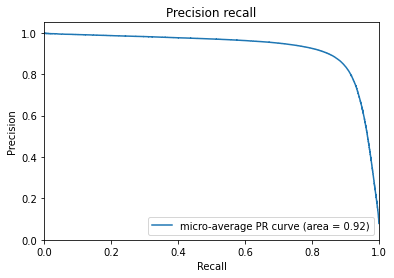

<Figure size 432x288 with 0 Axes>

In [ ]:
# evaluate the outcome based on testing model
loss,accuracy,precision,recall = modelGo.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %f' % (accuracy*100))
print('Test Precision: %f' % (precision*100))
print('Test Recall: %f' % (recall*100))
plot_pr_auc(y_test,predicts,symptom_type)

In [ ]:
#save model
model.save('WordVec/WordVec_' + todayDate)
modelGo.save('WordVec/WordVec_Final_' + todayDate)
!ls

INFO:tensorflow:Assets written to: WordVec/WordVec_2021-11-09/assets
INFO:tensorflow:Assets written to: WordVec/WordVec_Final_2021-11-09/assets
2020VAERSDATA.csv	 Model_09_10_10Symptoms
2020VAERSSYMPTOMS.csv	 model.bin
2020VAERSVAX.csv	 test.txt
2021VAERSDATA.csv	 vaers_data_complete_2021_09_06
2021VAERSSYMPTOMS.csv	 vaers_data_complete_2021_09_08
2021VAERSVAX.csv	 vaers_data_complete_text_processed_2021-11-08.csv
BERT_roc.png		 WordEmbedding
data_complete_final.csv  WordVec


In [ ]:
#performance checking on each classes
for index_symptoms in range(len(symptom_type)):
  testScores  = metrics.accuracy_score(y_test[:,index_symptoms],predicts[:,index_symptoms].round())
  print("Best accuracy (on testing dataset) for %s: %.2f%%" % (symptom_type[index_symptoms],testScores*100))
  precision, recall, _  = metrics.precision_recall_curve(y_test[:,index_symptoms],predicts[:,index_symptoms].round())
  auc_score = metrics.auc(recall, precision)
  print('AUC score: %.3f' % auc_score)
  print(metrics.classification_report(y_test[:,index_symptoms],
                                      predicts[:,index_symptoms].round(),
                                      target_names=['Not '+symptom_type[index_symptoms],symptom_type[index_symptoms]],
                                      digits=4))

Best accuracy (on testing dataset) for SYMPTOMSdyspnoea: 98.23%
AUC score: 0.871
                      precision    recall  f1-score   support

Not SYMPTOMSdyspnoea     0.9912    0.9898    0.9905    118411
    SYMPTOMSdyspnoea     0.8580    0.8754    0.8666      8314

            accuracy                         0.9823    126725
           macro avg     0.9246    0.9326    0.9286    126725
        weighted avg     0.9825    0.9823    0.9824    126725

Best accuracy (on testing dataset) for SYMPTOMSpyrexia: 97.30%
AUC score: 0.939
                     precision    recall  f1-score   support

Not SYMPTOMSpyrexia     0.9910    0.9752    0.9830    101557
    SYMPTOMSpyrexia     0.9059    0.9642    0.9342     25168

           accuracy                         0.9730    126725
          macro avg     0.9485    0.9697    0.9586    126725
       weighted avg     0.9741    0.9730    0.9733    126725

Best accuracy (on testing dataset) for SYMPTOMSchest pain: 98.68%
AUC score: 0.800
            

In [ ]:
!pip install -U tensorflow-addons
#confusion matrix from tensorflow for handling multi-label classification
import tensorflow_addons as tfa
tfa_metrics_multilabel = tfa.metrics.MultiLabelConfusionMatrix(num_classes=len(symptom_type))
tfa_metrics_multilabel.update_state(y_test, predicts.round())
tfa_metrics_multilabel.result()

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


<tf.Tensor: shape=(41, 2, 2), dtype=float32, numpy=
array([[[1.17206e+05, 1.20500e+03],
        [1.03600e+03, 7.27800e+03]],

       [[9.90370e+04, 2.52000e+03],
        [9.01000e+02, 2.42670e+04]],

       [[1.21835e+05, 6.06000e+02],
        [1.07200e+03, 3.21200e+03]],

       [[9.51230e+04, 1.26500e+03],
        [7.90000e+02, 2.95470e+04]],

       [[1.01849e+05, 7.42000e+02],
        [5.11000e+02, 2.36230e+04]],

       [[1.22617e+05, 4.16000e+02],
        [8.96000e+02, 2.79600e+03]],

       [[1.22644e+05, 1.50000e+01],
        [4.03200e+03, 3.40000e+01]],

       [[1.08507e+05, 5.97000e+02],
        [1.13000e+03, 1.64910e+04]],

       [[1.19923e+05, 5.84000e+02],
        [1.89600e+03, 4.32200e+03]],

       [[1.22143e+05, 5.38000e+02],
        [2.87000e+03, 1.17400e+03]],

       [[6.73050e+04, 5.25500e+03],
        [1.76600e+03, 5.23990e+04]],

       [[1.07672e+05, 1.19000e+03],
        [7.28000e+02, 1.71350e+04]],

       [[1.23798e+05, 4.13000e+02],
        [8.48000e+02, 1.

In [ ]:
#confusion matrix for each class
for index_symptoms in range(len(symptom_type)):
  confusion   = metrics.confusion_matrix(y_test[:,index_symptoms],predicts[:,index_symptoms].round())
  print(symptom_type[index_symptoms]+" Confusion Matrix:")
  print(confusion)
  print()

SYMPTOMSdyspnoea Confusion Matrix:
[[117206   1205]
 [  1036   7278]]

SYMPTOMSpyrexia Confusion Matrix:
[[99037  2520]
 [  901 24267]]

SYMPTOMSchest pain Confusion Matrix:
[[121835    606]
 [  1072   3212]]

SYMPTOMSheadache Confusion Matrix:
[[95123  1265]
 [  790 29547]]

SYMPTOMSfatigue Confusion Matrix:
[[101849    742]
 [   511  23623]]

SYMPTOMScovid-19 Confusion Matrix:
[[122617    416]
 [   896   2796]]

SYMPTOMSblood test Confusion Matrix:
[[122644     15]
 [  4032     34]]

SYMPTOMSnausea Confusion Matrix:
[[108507    597]
 [  1130  16491]]

SYMPTOMSasthenia Confusion Matrix:
[[119923    584]
 [  1896   4322]]

SYMPTOMScomputerised tomogram Confusion Matrix:
[[122143    538]
 [  2870   1174]]

SYMPTOMSpain Confusion Matrix:
[[67305  5255]
 [ 1766 52399]]

SYMPTOMSdizziness Confusion Matrix:
[[107672   1190]
 [   728  17135]]

SYMPTOMSsars-cov-2 test positive Confusion Matrix:
[[123798    413]
 [   848   1666]]

SYMPTOMSvomiting Confusion Matrix:
[[119474    424]
 [  1452   

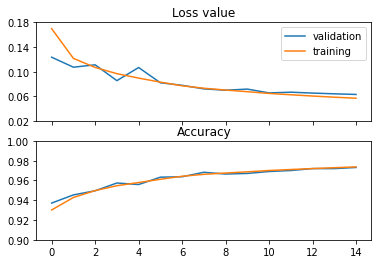

In [ ]:
#plot the training
records     = pd.read_csv(folderpath + modelname + "_" + todayDate + '.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.02,0.06,0.10,0.14,0.18])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_binary_accuracy'],label="validation")
plt.plot(records['binary_accuracy'],label="training")
plt.yticks([0.9,0.92,0.94,0.96,0.98,1.0])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

In [ ]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

print("Path to plot:", plotpath)

Path to plot: WordVec/WordVec_plot.png
